## Introduction

Welcome to Lesson 11 of the North Carolina Institute for Climate Studies' Machine Learning Course. Finally, 
we've arrived at neural networks (NN)! As mentioned in the lecture, NN are some of the most powerful and most
interesting ML algorithms out there. They happen to form the basis for my personal favorites, recurrent 
neural networks, and are capable of learning far more complex patterns than most of the algorithms that 
we've encountered thus far.

In this notebook, we'll be working with the most basic type of NN: the multilayer perceptron. We'll be 
using the same data set as the past several lessons: the US Climate Reference Network's (USCRN) soil 
moisture data from its Asheville station.

We will continue to attack the regression problem that we've worked on the past two lessons: attempting 
to estimate the soil moisture levels from precipitation data.

About the data set:
Refer to the USCRN_Daily_Data_readme.txt file in the repository for a complete description of this dataset.

## Preprocess the data

We are using the quality controlled daily station observations from US Climate Reference Network (USCRN). 
In this notebook, we will use the data of Asheville station with nearly 10 years of data. First, let's read 
in the data from the CSV (comma separated variable) file from [our repository](https://github.com/geo-yrao/ML4ES-tutorials/tree/master/00-Data/USCRN-data).

In [1]:
library( dplyr ); library( readr )  # load the library for reading and handaling data
## Define the file name of the CSV file
fname <- "https://raw.githubusercontent.com/geo-yrao/ML4ES-tutorials/master/00-Data/USCRN-data/USCRN-NC_Asheville_8_SSW_2010-2019.csv"

## Read in the RAW daily data
RawData <- read.csv(fname)

## Check the column names of the tabular data
print ( colnames(RawData) )

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




 [1] "WBANNO"                  "LST_DATE"               
 [3] "CRX_VN"                  "LONGITUDE"              
 [5] "LATITUDE"                "T_DAILY_MAX"            
 [7] "T_DAILY_MIN"             "T_DAILY_MEAN"           
 [9] "T_DAILY_AVG"             "P_DAILY_CALC"           
[11] "SOLARAD_DAILY"           "SUR_TEMP_DAILY_TYPE"    
[13] "SUR_TEMP_DAILY_MAX"      "SUR_TEMP_DAILY_MIN"     
[15] "SUR_TEMP_DAILY_AVG"      "RH_DAILY_MAX"           
[17] "RH_DAILY_MIN"            "RH_DAILY_AVG"           
[19] "SOIL_MOISTURE_5_DAILY"   "SOIL_MOISTURE_10_DAILY" 
[21] "SOIL_MOISTURE_20_DAILY"  "SOIL_MOISTURE_50_DAILY" 
[23] "SOIL_MOISTURE_100_DAILY" "SOIL_TEMP_5_DAILY"      
[25] "SOIL_TEMP_10_DAILY"      "SOIL_TEMP_20_DAILY"     
[27] "SOIL_TEMP_50_DAILY"      "SOIL_TEMP_100_DAILY"    


In this notebook, we focus on the problem of estimating the average soil moisture at 5 cm below the 
surface (_**SOIL_MOISTURE_5_DAILY**_) using other meteorological variables. To keep the model simple,
we just use the daily average (or total) of air temperature, precipitation, solar energy, surface 
temperature, and relative humidity as the model input. Therefore, we need to simplify our current 
tabular data to only keep necessary variables.  


In [2]:
### we only keep part of the variables for the application.
## In addition to the input variables, we kept date to help us separate the data for training/testing
SlimData <- RawData %>% dplyr::select (., c(2, 9, 10, 11, 15, 18, 19))

## Change coloum names for simple display purpose
colnames(SlimData) <- c("Date", "T2m", "Precip", "Solar", "Tskin", "RH", "SM_5cm")

## Check the first & last 10 rows of the data
head(SlimData, 10) 
tail(SlimData, 10)

,Date,T2m,Precip,Solar,Tskin,RH,SM_5cm
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20100101,0.6,0,7.54,1.4,73.8,NA
2,20100102,-7.1,0,8.07,-5.4,59.3,NA
3,20100103,-9.2,0,5.16,-7.7,54.9,NA
4,20100104,-8.1,0,9.30,-5.9,62.3,NA
5,20100105,-6.9,0,7.54,-5.3,67.1,NA
6,20100106,-5.8,0,9.24,-4.7,67.9,NA
7,20100107,-2.5,0,5.68,-1.2,64.9,NA
8,20100108,-9.1,0,8.79,-7.0,66.3,NA
9,20100109,-8.0,0,8.73,-5.9,62.0,NA


,Date,T2m,Precip,Solar,Tskin,RH,SM_5cm
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3643,20191222,3.1,13.3,0.96,2.9,91.3,NA
3644,20191223,8.3,12.4,0.96,7.7,97.6,NA
3645,20191224,8.9,0.0,8.00,7.4,90.4,NA
3646,20191225,5.0,0.0,7.49,3.5,84.4,NA
3647,20191226,5.4,0.0,8.12,3.5,80.8,NA
3648,20191227,6.2,0.0,5.85,4.8,82.5,NA
3649,20191228,9.6,1.0,6.67,7.7,81.0,NA
3650,20191229,15.0,13.5,2.19,13.6,93.7,NA
3651,20191230,11.5,1.2,8.52,9.1,69.9,NA


In addition, we added one more variable called "SM_10cm_lead" which is the soil moisture data
from the previous day.

In [3]:
SlimData$SM_5cm_lead <-  lag(SlimData$SM_5cm, n=1)
str(SlimData)

'data.frame':	3652 obs. of  8 variables:
 $ Date       : int  20100101 20100102 20100103 20100104 20100105 20100106 20100107 20100108 20100109 20100110 ...
 $ T2m        : num  0.6 -7.1 -9.2 -8.1 -6.9 -5.8 -2.5 -9.1 -8 -6.9 ...
 $ Precip     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Solar      : num  7.54 8.07 5.16 9.3 7.54 9.24 5.68 8.79 8.73 9.71 ...
 $ Tskin      : num  1.4 -5.4 -7.7 -5.9 -5.3 -4.7 -1.2 -7 -5.9 -5 ...
 $ RH         : num  73.8 59.3 54.9 62.3 67.1 67.9 64.9 66.3 62 59.5 ...
 $ SM_5cm     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ SM_5cm_lead: num  NA NA NA NA NA NA NA NA NA NA ...


We can see that there are missing values in both the independent variables and dependent variables in the 
current data set. Let's see how many missing values exist in the current data set.  

In [4]:
## Summarize the missing value
missingSum <- SlimData %>% 
  select_if(function(x) any(is.na(x))) %>%           ## Check if the column contains missing value
  summarise_all(funs(sum(is.na(.)/length(.)*100)))   ## if so, then count what percent of the data is missing

print("Percentage of missing values in each variable")
missingSum %>% knitr::kable()

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] "Percentage of missing values in each variable"




|       T2m|   Precip|     Solar|     Tskin|        RH|   SM_5cm| SM_5cm_lead|
|---------:|--------:|---------:|---------:|---------:|--------:|-----------:|
| 0.4928806| 1.040526| 0.4654984| 0.4654984| 0.4654984| 36.03505|    36.03505|

It appears that there is ~36% of data records has missing value for the soil moisture. To proceed with 
model development, we will only keep the complete daily data records in this notebook. In the future, 
we will introduce how to impute missing values for more complex model development.  

In [5]:
CleanData <- SlimData %>% filter(!is.na(T2m), !is.na(Precip),
                                 !is.na(Solar), !is.na(Tskin),
                                 !is.na(RH), !is.na(SM_5cm), 
                                 !is.na(SM_5cm_lead))

str(CleanData)

'data.frame':	2298 obs. of  8 variables:
 $ Date       : int  20100121 20100122 20100123 20100124 20100125 20100126 20100127 20100128 20100129 20100130 ...
 $ T2m        : num  3.5 3 3.6 6.6 6.7 -1 -0.9 2.7 0.5 -2.3 ...
 $ Precip     : num  12.1 0.5 0.3 71.5 0.6 0 0 0 20.7 13.7 ...
 $ Solar      : num  1.25 4.8 1.76 1.13 10.99 ...
 $ Tskin      : num  3.9 4 4.1 6.2 7.3 -0.3 0.1 2.9 0.7 -1.8 ...
 $ RH         : num  95.8 95.2 93.6 94.6 70.6 65.4 68.3 66.4 69.2 89.6 ...
 $ SM_5cm     : num  0.38 0.39 0.363 0.419 0.42 0.379 0.361 0.354 0.35 0.357 ...
 $ SM_5cm_lead: num  0.354 0.38 0.39 0.363 0.419 0.42 0.379 0.361 0.354 0.35 ...


Before we implement model development, we want to check the relationship between our variables.
We can examine the correlation between our variables pairwise except the date using function
[_ggpairs()_](https://www.blopig.com/blog/2019/06/a-brief-introduction-to-ggpairs/).

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



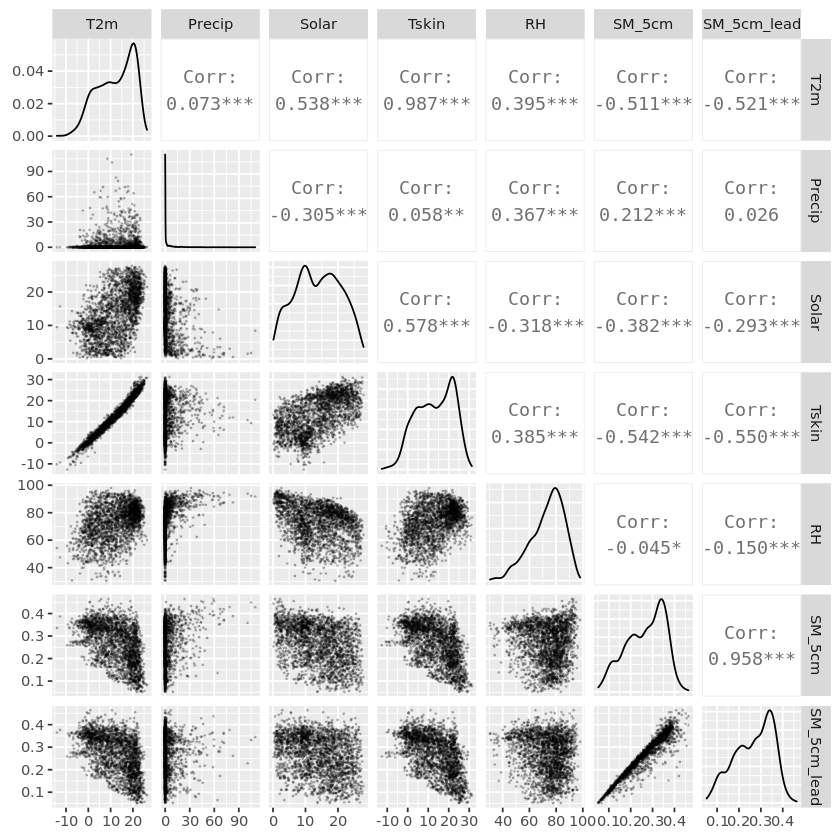

In [7]:
library(GGally)
ggpairs(CleanData, columns = c(2:8),
        lower = list(continuous = wrap("points", alpha = 0.2, size=0.2)))

It appears that the relative humidity (RH) does not show strong correlation with soil moisture,
so we will remove it from our future model development.

Right now, the *Date* variable is in the format of integer. We need to transform it into the 
specific format for datetime in R so we can perform time based filtering for training/testing data 
spliting.  

In [8]:
## Convert data type for LST_DATE to Date in R following the format "YYYY-MM-DD"
CleanData$Date <- as.Date(as.character(CleanData$Date), format="%Y%m%d")
str(CleanData)

## You will see the data type for LST_DATE has been changed into "Date"
## with this data type, we can easily filter data by observation date for train/test data spliting

## Let's use the data between 2010 and 2014 (5 years) for training our model
## then, use the data after 2015 for model evaluation
trainData <- CleanData %>% filter(Date <= "2014-12-31"); dim(trainData)
testData  <- CleanData %>% filter(Date >= "2015-01-01"); dim(testData)

'data.frame':	2298 obs. of  8 variables:
 $ Date       : Date, format: "2010-01-21" "2010-01-22" ...
 $ T2m        : num  3.5 3 3.6 6.6 6.7 -1 -0.9 2.7 0.5 -2.3 ...
 $ Precip     : num  12.1 0.5 0.3 71.5 0.6 0 0 0 20.7 13.7 ...
 $ Solar      : num  1.25 4.8 1.76 1.13 10.99 ...
 $ Tskin      : num  3.9 4 4.1 6.2 7.3 -0.3 0.1 2.9 0.7 -1.8 ...
 $ RH         : num  95.8 95.2 93.6 94.6 70.6 65.4 68.3 66.4 69.2 89.6 ...
 $ SM_5cm     : num  0.38 0.39 0.363 0.419 0.42 0.379 0.361 0.354 0.35 0.357 ...
 $ SM_5cm_lead: num  0.354 0.38 0.39 0.363 0.419 0.42 0.379 0.361 0.354 0.35 ...


[1] 1745    8

[1] 553   8

We now have two different data sets for model development (*trainData*) and model evaluation (*testData*)
seperately.

**Cautionary note**: when we split the data into two based on year, there is the underlying assumption 
that we believe the *trainData* (2010-2014) comes from the same statistical distribution with the *testData*
(2015-2019). In other words, the dataset used for model development could mostly represent the scenarios
that may appear in the dataset for model evaluation. But if there are future extreme events that is beyond the
range of *trainData*, we need to treat the prediction carefully since it could have large uncertainties.  

## Multiple Layer Perceptron (MLP)

Now, it's time to actually train the MLP regression model. In this notebook, we are using the powerful
machine learning library [Kersa](https://keras.rstudio.com/). **Kersa** is a crucial part of the 
[TensorFlow](https://tensorflow.rstudio.com/) ecosystem originally developed by Google Brain Team. 
It will be your gateway to future deep learning models. It is a good time to get
your feet wet in the fast developing field of deep learning using a more intuitive MLP model.

If you want to learn more about the structure of MLP, this [Towards Data Science blog post](https://towardsdatascience.com/simple-introduction-to-neural-networks-ac1d7c3d7a2c) provides
a very detailed walk through of the fundamentals of the MLP model and how the model training process
is performed at the back end. 

The R package **keras** is an high level interface to call core functions from Keras and TensorFlow
which are developed outside R. This type of cross platform packages have made it much easier to take
advantage of the raipdly developing machine learning landscape in R. We will still use **caret** as 
the interface to continue our consistent modeling framework from previous tutorials.  

Again, let's first check the model information of the MLP model in Keras using *getModelInfo()*. The 
model tag of MLP in Keras that we use here is *"mlpKerasDecay"*.

In [9]:

library(caret); library(keras)

## Getting model information using getModelInfo()
getModelInfo("mlpKerasDecay")


Loading required package: lattice



parameter,class,label
<chr>,<chr>,<chr>
size,numeric,#Hidden Units
lambda,numeric,L2 Regularization
batch_size,numeric,Batch Size
lr,numeric,Learning Rate
rho,numeric,Rho
decay,numeric,Learning Rate Decay
activation,character,Activation Function
parameter,class,label
<chr>,<chr>,<chr>


Once we have the model information, we can now define the parameter grids that we want to
search through. For the sake of efficiency, we are jsut changing the value of the activation
function and the L2-regularization in the tutorial.  

Let's try these combination of the hyperparameters:

-- Activation function: ReLU (rectified linear unit), sigmoid, linear, and tanh  

-- L2-regularization (lambda): 0.0001, 0.1, 1 (the larger the value, the heavier penalty for overfitting)


In [10]:
### In this block, we are defining the hyperparameter grid that we want to search through
### To reduce the computational load for the tutorial, we only choose two hyperparameter 
### in this notebook - activation function, and L2-regularization

para_grid <- expand.grid(
    activation = c("relu", "sigmoid", "linear", "tanh"), # four different activation function
    lambda     = c(0.0001, 0.1, 10), # three different L2-regularization value
    lr = 2e-6,  ## Default learning rate
    rho = .9,   ## Default Rho
    decay = 0,  ## Default learning rate decay 
    batch_size = 8, ## Default batch size
    size  =  10)   ## Defalut node numbers)


So now we should have a parameter grid of 12 different combinations to search through for the 
best model structure. We can use the *train()* function in **caret** package for a 5-fold cross
validation for model training.  

First of all, we need to scale all data to avoid that some large magnitute variables may dominate 
the model performance.

In [11]:
## we will use preProcess function to do the scaling
## Also, we are not scaling the date for the data
preProc <- preProcess(trainData[,2:8], method = c("center", "scale"))

## Now, we apply the preprocessing steps to both training data and testing data
trainScaled <- predict(preProc, newdata=trainData)
testScaled  <- predict(preProc, newdata=testData)

While at this stage, you will be asked to install miniconda in order to implement the Keras since
it requires the python core for the functions. You can simply type "Y" to continue the installation.

In [ ]:
### To specify that we want to do 5-fold CV, we need to use the function trainControl() from *caret*.
trCtrl <- trainControl(method="cv", number=5, 
                       search="grid")

library(tensorflow); library(keras)
### Using train function to train the MLP model
## target : Soil Moisture at 5 cm SM_5cm
## input  : T2m, Precip, Solar, Tskin
MLP <- caret::train(SM_5cm ~ T2m + Precip + Solar + Tskin,
                data = trainScaled, method = "mlpKerasDecay", 
                tuneGrid = para_grid,
                trControl = trCtrl)

### Now we have our mlp GPR model with the optimized hyperparameter
MLP


With this multilayer perceptron model by accounting for the "memory" from previous day, 
our model achieves the coefficient of determination (R^{2}) of 0.45. Let's see how this model will 
perform on the testing data that we set asside. 

In [ ]:
### First, we apply the model to the test data by using function predict()
mlpPredicted <- predict(MLP, newdata = testScaled)

### Now, we want to calculate the RMSE, R^2, and mean absolute error (MAE) using 
### postResample() function
mlpTesting <- postResample(mlpPredicted, testData$SM_5cm)

mlpTesting

The GPR model estimation shows a very good performance with R^{2} reaching 0.96 and RMSE of 0.25 for 
the scaled soil moisture value.  

Now, we can visualize our model performance by ploting the true value and the estimation against the 
date.

In [ ]:
## Define the result data frame first for ggplot
result <- data.frame(Date = testScaled$Date, 
                     Scaled_USCRN_SM_5cm = testScaled$SM_5cm,
                     Scaled_MLP_SM_5cm = mlpPredicted)

## Note that all values are scaled values in the preProcessing step
ggplot(aes(x=Date), data=result) +
    geom_point(aes(y=Scaled_USCRN_SM_5cm), color = "royalblue", pch=21) +
    geom_point(aes(y=Scaled_MLP_SM_5cm), color = "black", pch=21) +
    theme_bw() + labs(x = "Date", y = "Scaled Soil Moisture at 5 cm")

This model estimation does not look very promising since it did not capture the data dynamics in the estimation. 
If you noticed that we did not include the lagged soil moisture from the previous day as our model input.
With the Gaussian Process Regression, we demonstrated that adding an additional variable which is the previous day's 
soil moisture to improve the model performance by accounting for the soil "memory". So here comes the exercise for you.  

Can you build a MLP model by adding the previous day soil moisture data to improve the model performance? 

In [ ]:

### You should have all the building blocks for building the model
### The data is the same, you just need to add an additional input variable to
### develop the new model.

### Can you compare this model output and the previous model estimation?
